In [1]:
# Imports
import os
import pandas as pd
from datetime import datetime
import numpy as np

In [2]:
#Constants and Vars
TC_CSX = {'hp': 158, 'torque': 139, 'mass':1313}
TC = TC_CSX
hpmratio = TC['hp'] / TC['mass']
tmratio = TC['torque'] / TC['mass']


DATA_FILE = '26'
DATA_FILES = [26,27,28,31,32,33,34,36,37,38,40]
DATA_FOLDER = 'hwd_data2'
FILE_NAME = "{}/run_{}.csv".format(DATA_FOLDER, DATA_FILE)
SAVE_FOLDER = 'hwd_processed'
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)

In [3]:
# df_in = pd.read_csv(FILE_NAME,header=None,sep=',', names=['date', 'speed', 'engine_load','throttle','rpm',
#                                                       'heading', 'roll', 'pitch',
#                                                       'sys', 'gyro', 'accel', 'mag',
#                                                       'magx', 'magy', 'magz',
#                                                       'gyrx', 'gyry', 'gyrz',
#                                                       'linaccx', 'linaccy', 'linaxxz'
#                                                      ])

In [4]:
def format_df(f_name):
    df = pd.read_csv(FILE_NAME,header=None,sep=',', names=['date', 'speed', 'engine_load','throttle','rpm',
                                                      'heading', 'roll', 'pitch',
                                                      'sys', 'gyro', 'accel', 'mag',
                                                      'magx', 'magy', 'magz',
                                                      'gyrx', 'gyry', 'gyrz',
                                                      'linaccx', 'linaccy', 'linaxxz'
                                                     ])
    df['time'] = (df.date - df.date.iloc[0])
    df['time_diff'] = df.time.diff()
    df['speed'] = df.speed.str.replace(' kph','')
    df['engine_load'] = df.engine_load.str.replace(' percent', '')
    df['throttle'] = df.throttle.str.replace(' percent', '')
    df['rpm'] = df.rpm.str.replace(' revolutions_per_minute', '')

    obd2_cols = ['speed', 'engine_load', 'throttle', 'rpm']
    for col in obd2_cols:
        df[col].replace('None', np.nan,inplace=True)
        df[col] = df[col].apply(np.float64)
        df[col] = df[col].interpolate(limit=4,direction='both')
    df = df[1:-1]

    min_throttle = df.throttle.min()
    df['throttle'] = df['throttle'] * (1+0.01*min_throttle) - min_throttle
    df = df[df.speed > 0]

    df['lateral_velocity'] = df.heading.diff() / df.time_diff
    df['speed_diff'] = df.speed.diff()
    return df

def calculate_score(row, average_score, max_score, attribute):
    
    final_score = 0
    
    if (attribute != 'Braking' and row[attribute] >= max_score) or (attribute == 'Braking' and row[attribute] <= max_score):
        return 5
    else: 
        if attribute == 'Braking':
            #Calculating braking is inverted, lower is better thus the if condition is different
            if row[attribute] < average_score: 
                calculate_difference= (max_score - row[attribute])/(max_score-average_score)
                final_score = 5 - 2.5 * calculate_difference
            else: 
                final_score = (average_score/row[attribute]) * 2.5
        elif row[attribute] > average_score:
            calculate_difference= (row[attribute] - average_score)/(max_score - average_score)
            final_score = 2.5 + 2.5 * calculate_difference
        else:
            final_score = (row[attribute]/average_score * 2.5)
            
    return final_score

In [5]:
# HP
test_df = format_df(FILE_NAME)

#test_df
#test_hp = test_df[test_df.rpm > 2500][test_df.speed_diff >= 0]
#test_hp['hp_score'] = test_hp.speed_diff * test_hp.throttle
#print('HP_SCORE: ',test_hp['hp_score'].mean()/hpmratio)
# Breaking on speed diff??? Then calculate acceleration based on derivative?

6.326787092534384 6.666673024501506 1.25000119209 16.6666825613


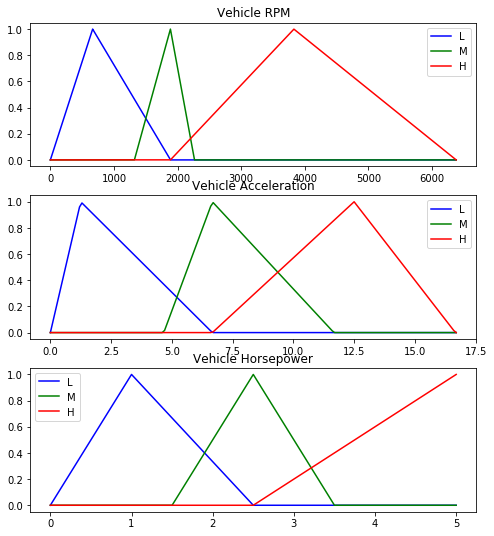

In [160]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
%matplotlib inline


def calculate_horsepower():

    average_rpm = test_df['rpm'].median()
    max_rpm = test_df['rpm'].max()
    min_rpm = test_df['rpm'].min()

    average_rpm_test_run = 2600

    rpm = np.arange(0, max_rpm + 1, 1)
    rpm_set = ctrl.Antecedent(rpm, 'rpm')

    # Generate fuzzy membership functions
    rpm_lo = fuzz.trimf(rpm, [0, min_rpm, average_rpm])
    rpm_md = fuzz.trimf(rpm, [0.7 * average_rpm, average_rpm, average_rpm * 1.2])
    rpm_hi = fuzz.trimf(rpm, [average_rpm, max_rpm*0.6, max_rpm])

    rpm_set['L'] = fuzz.trimf(rpm, [0, min_rpm, average_rpm])
    rpm_set['M'] = fuzz.trimf(rpm, [0.7 * average_rpm, average_rpm, average_rpm * 1.2])
    rpm_set['H'] = fuzz.trimf(rpm, [average_rpm, max_rpm*0.6, max_rpm])

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

    ax0.plot(rpm, rpm_lo, 'b', linewidth=1.5, label='L')
    ax0.plot(rpm, rpm_md, 'g', linewidth=1.5, label='M')
    ax0.plot(rpm, rpm_hi, 'r', linewidth=1.5, label='H')
    ax0.set_title('Vehicle RPM')
    ax0.legend()

    test_df['acc'] = test_df.speed_diff / test_df.time_diff

    acc_df = test_df[test_df.acc >0]

    average_acc = acc_df['acc'].median()
    max_acc = acc_df['acc'].max()
    min_acc = acc_df['acc'].min()

    print(acc_df['acc'].mean(), acc_df['acc'].median(), min_acc, max_acc)

    acc = np.arange(0, max_acc + 0.1, 0.1)

    acc_set = ctrl.Antecedent(acc, 'acc')

    # Generate fuzzy membership functions
    acc_lo = fuzz.trimf(acc, [0, min_acc, average_acc])
    acc_md = fuzz.trimf(acc, [0.7 * average_acc, average_acc, max_acc * 0.7])
    acc_hi = fuzz.trimf(acc, [average_acc, max_acc*0.75, max_acc])

    acc_set['L'] = fuzz.trimf(acc, [0, min_acc, average_acc])
    acc_set['M'] = fuzz.trimf(acc, [0.7 * average_acc, average_acc, max_acc * 0.7])
    acc_set['H'] = fuzz.trimf(acc, [average_acc, max_acc*0.75, max_acc])

    ax1.plot(acc, acc_lo, 'b', linewidth=1.5, label='L')
    ax1.plot(acc, acc_md, 'g', linewidth=1.5, label='M')
    ax1.plot(acc, acc_hi, 'r', linewidth=1.5, label='H')
    ax1.set_title('Vehicle Acceleration')
    ax1.legend()

    HP = np.arange(0, 5.1, 0.1)

    HP_set = fuzz.trimf(HP, [0, 1, 2.5])
    HP_md = fuzz.trimf(HP, [1.5, 2.5, 3.5])
    HP_hi = fuzz.trimf(HP, [2.5, 5, 5])

    HP_set = ctrl.Consequent(HP, 'HP')

    HP_set['L'] = fuzz.trimf(HP, [0, 1, 2.5])
    HP_set['M'] = fuzz.trimf(HP, [1.5, 2.5, 3.5])
    HP_set['H'] = fuzz.trimf(HP, [2.5, 5, 5])

    ax2.plot(HP, HP_lo, 'b', linewidth=1.5, label='L')
    ax2.plot(HP, HP_md, 'g', linewidth=1.5, label='M')
    ax2.plot(HP, HP_hi, 'r', linewidth=1.5, label='H')
    ax2.set_title('Vehicle Horsepower')
    ax2.legend()


    rule1 = ctrl.Rule(acc_set['L'] & rpm_set['L'], HP_set['L'])
    rule2 = ctrl.Rule(acc_set['L'] & rpm_set['M'], HP_set['M'])
    rule3 = ctrl.Rule(acc_set['L'] & rpm_set['H'], HP_set['H'])

    rule4 = ctrl.Rule(acc_set['M'] & rpm_set['L'], HP_set['L'])
    rule5 = ctrl.Rule(acc_set['M'] & rpm_set['M'], HP_set['H'])
    rule6 = ctrl.Rule(acc_set['M'] & rpm_set['H'], HP_set['H'])

    rule7 = ctrl.Rule(acc_set['H'] & rpm_set['L'], HP_set['L'])
    rule8 = ctrl.Rule(acc_set['H'] & rpm_set['M'], HP_set['H'])
    rule9 = ctrl.Rule(acc_set['H'] & rpm_set['H'], HP_set['H'])

    system = ctrl.ControlSystem(rules=[rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])

    HP_output = ctrl.ControlSystemSimulation(system)

    HP_output.input['acc'] = 2.5
    HP_output.input['rpm'] = 2500

    HP_output.compute()
    HP_output.output['HP']
        
calculate_horsepower()
